# Data inspection in BigQuery - comments dataset

The data set source is a pubblic collection of 1.7 billion reddit comments and posts loaded on BigQuery in this [link](https://bigquery.cloud.google.com/dataset/fh-bigquery:reddit_comments?pli=1)

# Comments statistic

Here below the steps followed that guided me to my conclusions of which subreddits I selected through comments_ds.

## BigQuery Authentication

As my data is in BigQuery, Colab is a perfect instrument to explore it.
First of all we need the authentication



In [0]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


and create the enviroment of my project:

In [0]:
%env GCLOUD_PROJECT=reddit-254019

env: GCLOUD_PROJECT=reddit-254019


## Global analysis

I start exploring only one year (2018) filtering the data by:

*   subreddit
*   author
*   count of comments
*   avg of score
*   year
*   month

In [0]:
%%bigquery --project reddit-254019
SELECT
      DISTINCT(subreddit) uniq_subreddit,
      COUNT(DISTINCT(author)) AS num_uniq_authors,
      COUNT(body) AS number_comments,
      ROUND(AVG(score), 2) as avg_score,
      EXTRACT(YEAR
      FROM
        TIMESTAMP_SECONDS(created_utc)) year,
      EXTRACT(month
      FROM
        TIMESTAMP_SECONDS(created_utc)) month
    FROM
      `fh-bigquery.reddit_comments.2018_*`
    GROUP BY
      1,
      5,
      6
    ORDER BY
      number_comments DESC,
      avg_score DESC

,uniq_subreddit,num_uniq_authors,number_comments,avg_score,year,month
0,AskReddit,893663,6003147,22.94,2018,12
1,AskReddit,857138,5834042,22.94,2018,10
2,AskReddit,769955,5765531,22.08,2018,8
3,AskReddit,726995,5652413,21.59,2018,7
4,AskReddit,834540,5615448,24.15,2018,11
...,...,...,...,...,...,...
1294890,u_MIldlyEvilShop,1,1,-11.00,2018,3
1294891,u_LuminoxUSA,1,1,-11.00,2018,6
1294892,181920,1,1,-12.00,2018,4
1294893,bgchatmemes,1,1,-26.00,2018,6


The result is not exactly helpfull. I need to dimension my data.

Analyze both, `number_comments` and `num_uniq_authors` together, can be inefficient. We can analyze the two parameters separately and see their behavior.

**Note**: I would like to use Altair to visualize my data but I'm tring to create a plot that will directly embed a dataset with more than 5000 rows, not supported from Altair, even using `alt.data_transformers.disable_max_rows()` the notebook desconnect the runtime.

Let see with a grafic on data studio.

In [0]:
from google.colab import files
uploaded = files.upload()

Saving numbComments_unicAuthors.png to numbComments_unicAuthors (1).png


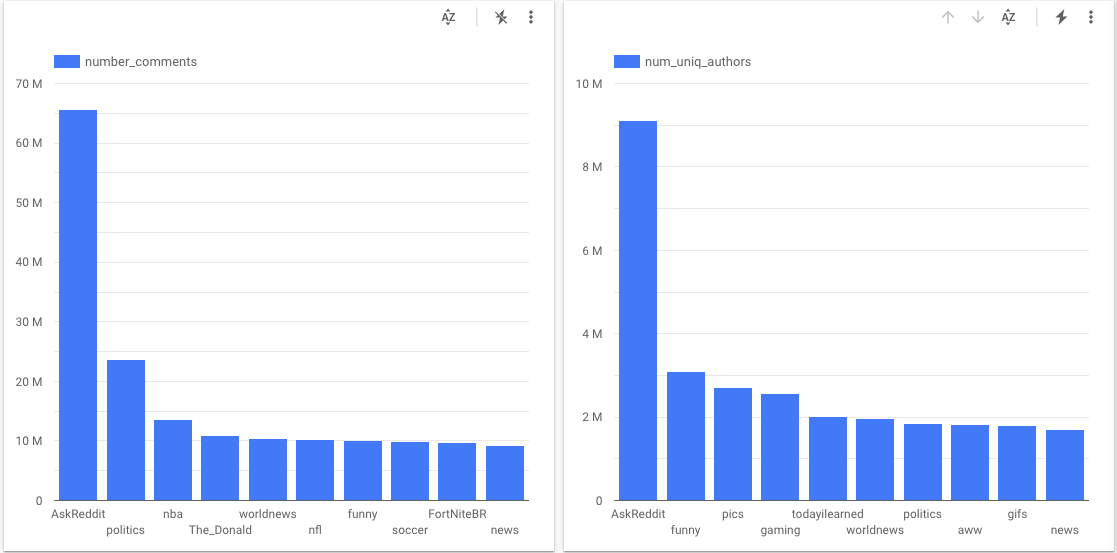

In [0]:
from IPython.display import Image
Image('numbComments_unicAuthors (1).png', width = 1000)

In this grafics we can see that the top number of comments in common with the top number of unique authors are 5 on 10. 
It can confirms a direct correlation.

Let's analyze also the avg of the score.

In [0]:
uploaded = files.upload()

Saving numbComments_avgScore.png to numbComments_avgScore.png


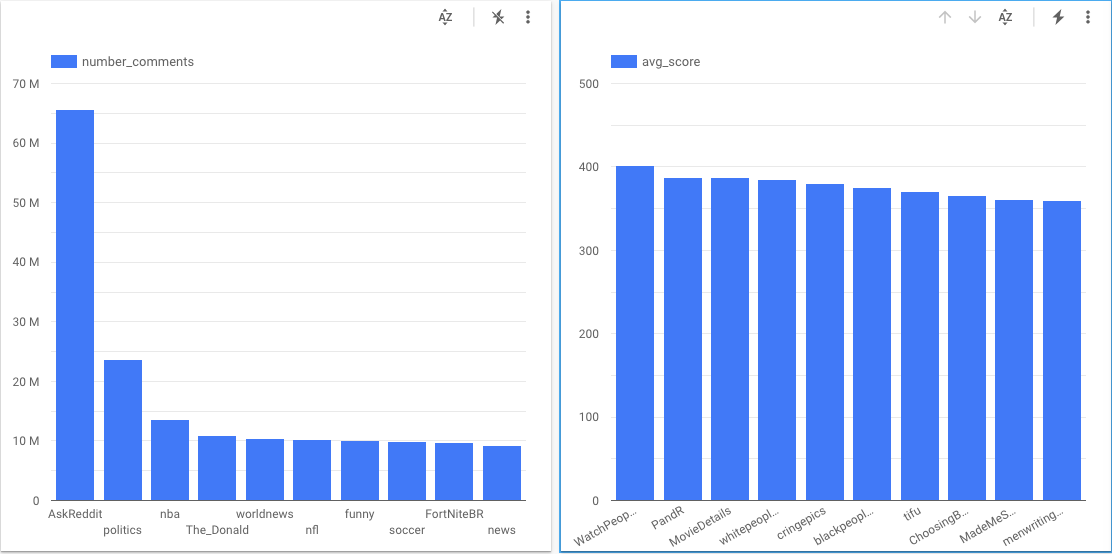

In [0]:
Image('numbComments_avgScore.png', width = 1000)

IMPORTANT: the data has not been normalized.

In this comparison we can see that there is not a direct correlation between the number of comments per subreddit and the avg score per subreddit. 

The problem with `score`is that there is no explication of how the number has been calculated in this dataset.




The limitation of this first analysis is that **we are only looking at the year 2018** (a significant year in terms of growth of the platform)

What we really need is do this analysis all year finding the subreddits that appears in a determined moment of reddit's life and begin popular during a long period of time.

To better know the data, is also good to study more about legth and avg of the comments (what finally will fead my nlp model).

First we can see that in `body` some comments has been removed or deleted:


In [0]:
%%bigquery --project reddit-254019
SELECT
  COUNT(body) AS selftext_not_valid,
  subreddit,
  body
FROM
  `fh-bigquery.reddit_comments.2018_11`
WHERE
  body = '[deleted]'
  OR body = '[removed]'
  OR body = '[ Removed by reddit in response to a copyright notice. ]' 
  OR body = 'NaN' 
  OR body = '' 
group by 2, 3

,selftext_not_valid,subreddit,body
0,1274,detroitlions,[deleted]
1,30848,soccer,[deleted]
2,38690,reddeadredemption,[removed]
3,266102,AskReddit,[deleted]
4,13388,mildlyinteresting,[deleted]
...,...,...,...
65429,20,bih,[removed]
65430,20,gamingpc,[removed]
65431,20,badphilosophy,[removed]
65432,20,MemePiece,[removed]


The final data will be selected and clean with the follow critera:



```sql
body != '[deleted]'
  AND body != '[removed]'
  AND body != '[ Removed by reddit in response to a copyright notice. ]' 
  AND body != 'NaN' 
  AND body != '' 
````


Important to analyze is also the lenght and the avg or the body of the subreddits:

In [0]:
%%bigquery --project reddit-254019
WITH
  q1 AS(
  SELECT
    subreddit,
    author,
    body,
    created_utc
  FROM
    `fh-bigquery.reddit_comments.2018_*`
  WHERE
    body != '[deleted]'
    AND body != '[removed]'
    AND body != '[ Removed by reddit in response to a copyright notice. ]'
    AND body != 'NaN'
    AND body != ''),
  q2 AS (
  SELECT
    subreddit,
    MAX(LENGTH(body)) AS max_char_body,
    MIN(LENGTH(body)) AS min_char_body,
    ROUND(AVG(LENGTH(body)),2) AS avg_length_body
    FROM
    q1
  GROUP BY
    1 )
SELECT
  subreddit,
  max_char_body,
  min_char_body,
  avg_length_body
FROM
  q2
ORDER BY
  max_char_body DESC
  --min_char_body ASC
  --avg_length_body DESC
  --avg_length_body ASC

,subreddit,max_char_body,min_char_body,avg_length_body
0,2b2t,432872,1,101.59
1,JacksFilms,405555,1,187.65
2,APStudents,366870,1,150.23
3,u_Koch_Industries,296889,1,1418.15
4,u_w2h3,290464,6,29082.10
...,...,...,...,...
412632,u_ormtim,1,1,1.00
412633,u_jawad42u,1,1,1.00
412634,u_import_sys,1,1,1.00
412635,PersonaSeries,1,1,1.00


Here a summary of the result changing the ```ORDER BY```

```
max_char_body = 432872
min_char_body = 1
max avg_length_body = 96915.67
min avg_length_body = 1,00

````

## Top subreddits per year - comments table

The final solution for my analysis is to extract:

- the top _n_ subreddits with more comments on it
- the top _n_ subreddit with more unique authors that writes on them
- __exclude the score param__ for the simple reason that I need more time to analyze the formula that compose the data showed (should be a formula composed with upvotes and downvoltes but is not clear how has been calculated as the two params are not indicated in the dataset)

Finally, with this data, I'll study each subreddit selecting:
- those with a costant popularity during the years
- those that cover a wider category threshold

For the last point I'll use the follow public classification in GitHub: [subreddit-Directory-Skeleton](https://github.com/MetASnoo/Subreddit-Directory-Skeleton/blob/master/subreddits.txt)

### Top comments in all years

The query will run all `reddit_comments` talble from 2005 to 2019. I should exclude 2005 because there are no subreddit a part of `reddit.com`but, for convenience I'll keep it.


With this query, I'll create a table with all comments per subreddit, year and month:

```sql
WITH
  q1 AS(
  SELECT
    subreddit,
    author,
    body,
    score,
    created_utc
  FROM
    `fh-bigquery.reddit_comments.20*`
  WHERE
    body != '[deleted]'
    AND body != '[removed]'
    AND body != '[ Removed by reddit in response to a copyright notice. ]'
    AND body != 'NaN'
    AND body != ''),
  q2 AS (
  SELECT
    DISTINCT(subreddit) uniq_subreddit,
    COUNT(DISTINCT(author)) AS num_uniq_authors,
    COUNT(body) AS number_comments,
    --ROUND(AVG(score), 2) as avg_score,
    EXTRACT(YEAR
    FROM
      TIMESTAMP_SECONDS(created_utc)) year,
    EXTRACT(month
    FROM
      TIMESTAMP_SECONDS(created_utc)) month
  FROM
    q1
  GROUP BY
    1,
    4,
    5
  ORDER BY
    number_comments DESC)
SELECT
  uniq_subreddit,
  num_uniq_authors,
  number_comments,
  year,
  month
FROM
  q2
ORDER BY
  number_comments DESC
````



Based in the result of the previous query, I've created a table where I decided to extract:

- __subreddit__
- __sum of comments__ : that gives me the most comments subreddits throughout the life of Reddit:
- __count of months__ :in order to identify the subreddits that has been commented during several months and years 
- __last year commented__: the las year where a comment has been done

limited in 100 results.

This gives me an idea of which subreddits deserve to be analyzed for my purpose.

__As 2019 is the last year commented and the months selected are more that 120 it gives me the security that the subreddits I select are the ones with more comments in several months and are still commented in 2019__

File name: __comments_top100.csv__

In [0]:
%%bigquery --project reddit-254019
SELECT
  *
FROM (
  SELECT
    uniq_subreddit,
    SUM(number_comments) AS total_comments,
    max(year) as last_year_commented,
    COUNT(month) AS number_of_months
  FROM
    `reddit-254019.reddit_comments.count_unique_authors_in_comments_allYears`
  GROUP BY
    uniq_subreddit
  ORDER BY
    total_comments DESC)
WHERE
  number_of_months > 120
LIMIT 100

,uniq_subreddit,total_comments,last_year_commented,number_of_months
0,AskReddit,438964917,2019,138
1,politics,102731735,2019,141
2,funny,85440060,2019,138
3,pics,77443968,2019,138
4,gaming,59167870,2019,140
...,...,...,...,...
95,circlejerk,2726704,2019,127
96,Parenting,2717639,2019,136
97,Economics,2712648,2019,138
98,chicago,2624212,2019,133


### Top unique authors in all years


Unique authors (the number of authors that wrote a comment) will follow the same tratment of comments.
The query will be the same as the previous but this time, order by the number of unique authors.

```sql
SELECT
      DISTINCT(subreddit) uniq_subreddit,
      COUNT(DISTINCT(author)) AS num_uniq_authors,
      COUNT(body) AS number_comments,
      --ROUND(AVG(score), 2) as avg_score,
      EXTRACT(YEAR
      FROM
        TIMESTAMP_SECONDS(created_utc)) year,
      EXTRACT(month
      FROM
        TIMESTAMP_SECONDS(created_utc)) month
    FROM
      `fh-bigquery.reddit_comments.20*`
    GROUP BY
      1,
      4,
      5
    ORDER BY
      num_uniq_authors DESC
```

Based in the result of the previous query, I've created a table where I decided to extract to inspect:

- __subreddit__
- __sum of unique authors__ (that gives me the most "famous" subreddits throughout the life of Reddit)
- __count of months__ in order to identify the subreddits that has been commented during several months and yeras
- __last year commented__: the las year where a comment has been done

limited in 100 results.

Once again, this gives me an idea of which subreddits deserve to be analyzed for my purpose.

__As 2019 is the last year commented and the months selected are more that 120 it gives me the security that the subreddits I select are the ones with more comments from unique authors in several months and are still commented in 2019__

File name: __authors_top100.csv__


In [0]:
%%bigquery --project reddit-254019
SELECT
  *
FROM (
  SELECT
    uniq_subreddit,
    SUM(num_uniq_authors) AS total_authors,
    max(year) as last_year_commented,
    COUNT(month) AS number_of_months
  FROM
    `reddit-254019.reddit_comments.count_unique_authors_in_comments_allYears`
  GROUP BY
    uniq_subreddit
  ORDER BY
    total_authors DESC)
WHERE
  number_of_months > 120
LIMIT 100

,uniq_subreddit,total_authors,last_year_commented,number_of_months
0,AskReddit,56027839,2019,138
1,funny,22790317,2019,138
2,pics,21569458,2019,138
3,gaming,15420264,2019,140
4,videos,13292001,2019,138
...,...,...,...,...
95,running,537210,2019,122
96,vegan,529745,2019,133
97,geek,523193,2019,138
98,investing,515051,2019,132


From these last two results I'll select my subreddits to be used in my analysis